# Fake news detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [2]:
fake = pd.read_csv("E:\ADITI\RVU\SEM4\IML\FAKE NEWS DETECTION\FINAL PRESENTATION\CODE\Fake.csv")
true = pd.read_csv("E:\ADITI\RVU\SEM4\IML\FAKE NEWS DETECTION\FINAL PRESENTATION\CODE\True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [5]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [6]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
# Check the data
data.head()

,title,text,subject,date,target
0,Obama’s DOJ Just Got Serious About Institutio...,One of the positive effects of the racial tens...,News,"March 14, 2016",fake
1,Senate panel advances nomination of Quarles to...,WASHINGTON (Reuters) - A U.S. Senate committee...,politicsNews,"September 7, 2017",true
2,BET Had More Than A Few Things To Say To Stac...,By now you ve probably heard about the remarks...,News,"January 20, 2016",fake
3,WATCH: Powerful Video PERFECTLY Explains How ...,One of the greatest strategies to gain and hol...,News,"March 13, 2016",fake
4,FORMER JOE BIDEN Secret Service Agent Claims T...,Several uncomfortable videos have surfaced thi...,politics,"Nov 15, 2017",fake


In [9]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Obama’s DOJ Just Got Serious About Institutio...,One of the positive effects of the racial tens...,News,fake
1,Senate panel advances nomination of Quarles to...,WASHINGTON (Reuters) - A U.S. Senate committee...,politicsNews,true
2,BET Had More Than A Few Things To Say To Stac...,By now you ve probably heard about the remarks...,News,fake
3,WATCH: Powerful Video PERFECTLY Explains How ...,One of the greatest strategies to gain and hol...,News,fake
4,FORMER JOE BIDEN Secret Service Agent Claims T...,Several uncomfortable videos have surfaced thi...,politics,fake


In [10]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,One of the positive effects of the racial tens...,News,fake
1,WASHINGTON (Reuters) - A U.S. Senate committee...,politicsNews,true
2,By now you ve probably heard about the remarks...,News,fake
3,One of the greatest strategies to gain and hol...,News,fake
4,Several uncomfortable videos have surfaced thi...,politics,fake


In [11]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,one of the positive effects of the racial tens...,News,fake
1,washington (reuters) - a u.s. senate committee...,politicsNews,true
2,by now you ve probably heard about the remarks...,News,fake
3,one of the greatest strategies to gain and hol...,News,fake
4,several uncomfortable videos have surfaced thi...,politics,fake


In [12]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [13]:
# Check
data.head()

,text,subject,target
0,one of the positive effects of the racial tens...,News,fake
1,washington reuters a us senate committee on t...,politicsNews,true
2,by now you ve probably heard about the remarks...,News,fake
3,one of the greatest strategies to gain and hol...,News,fake
4,several uncomfortable videos have surfaced thi...,politics,fake


In [14]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to C:\Users\ADITI
[nltk_data]     ANIL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
data.head()

,text,subject,target
0,one positive effects racial tension ferguson m...,News,fake
1,washington reuters us senate committee thursda...,politicsNews,true
2,probably heard remarks clueless star fox news ...,News,fake
3,one greatest strategies gain hold power large ...,News,fake
4,several uncomfortable videos surfaced week sho...,politics,fake


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


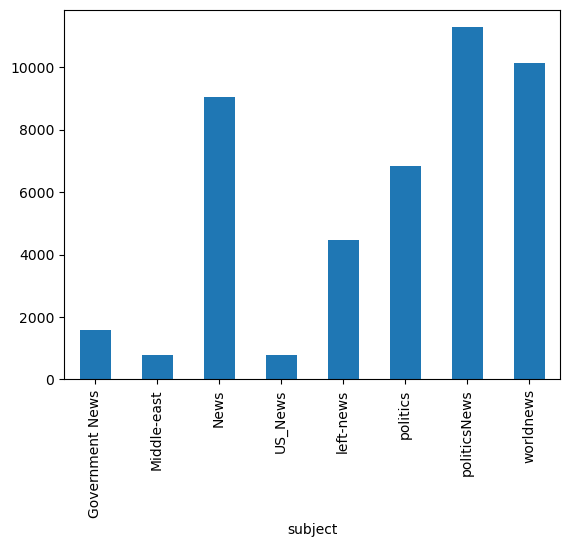

In [16]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


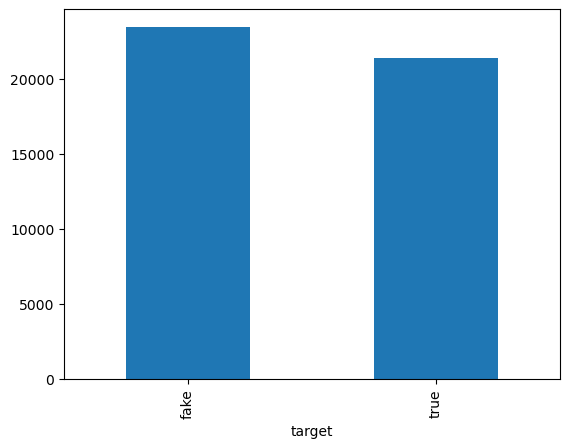

In [17]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

In [18]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

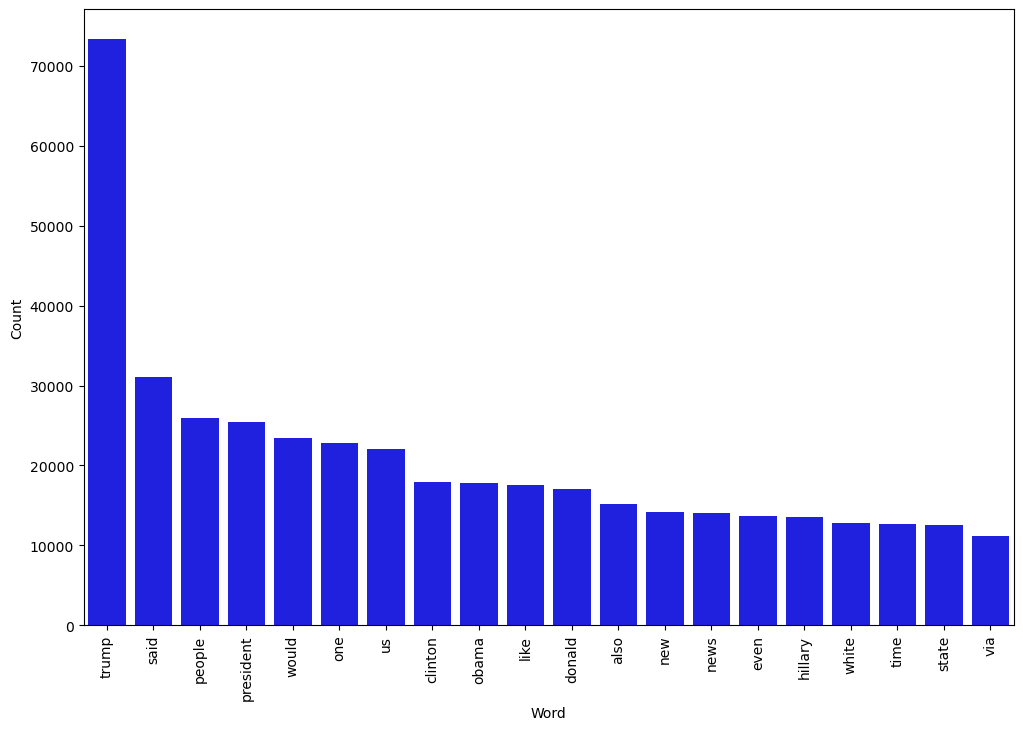

In [19]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

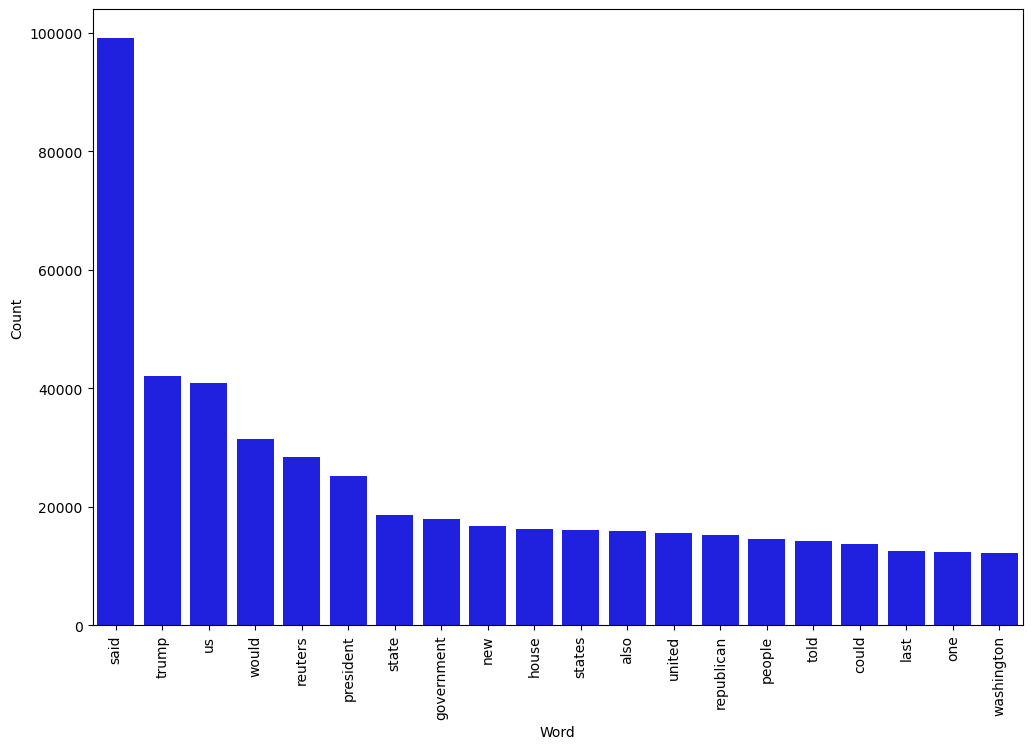

In [20]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [21]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [22]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

### Logistic regression

In [23]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.94%


Confusion matrix, without normalization


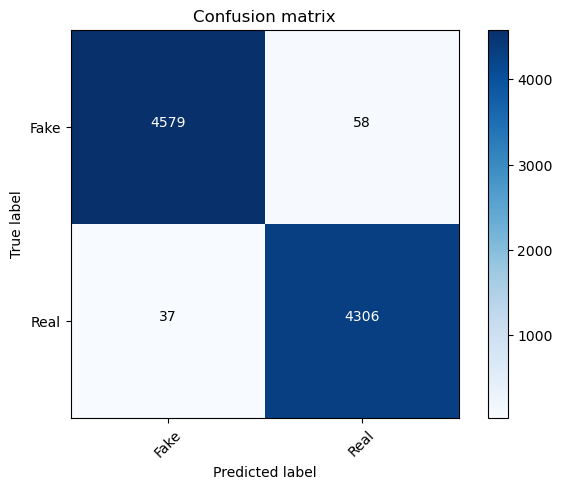

In [24]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Decision Tree Classifier

In [25]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20,
                                           splitter='best',
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.64%


Confusion matrix, without normalization


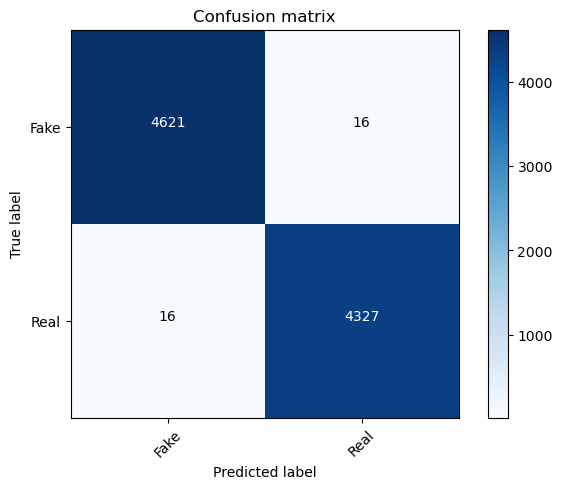

In [26]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Random Forest Classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.92%


Confusion matrix, without normalization


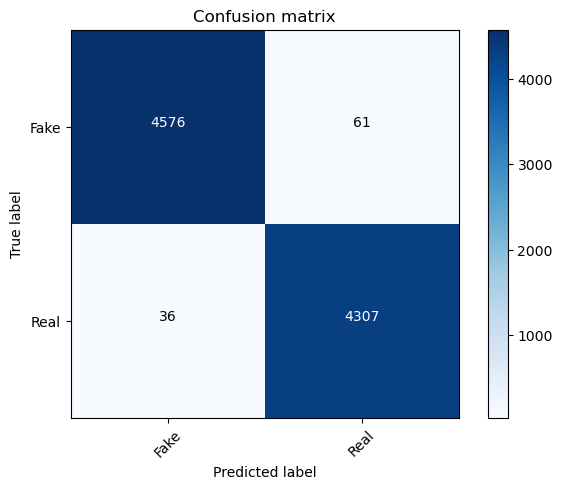

In [28]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score
from sklearn import svm


In [30]:
# Define SVM pipeline
svm_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', svm.SVC(kernel='linear', C=1.0))
])

# Train SVM
svm_model = svm_pipe.fit(X_train, y_train)

# Make predictions on test data
svm_prediction = svm_model.predict(X_test)

# Evaluate model performance
print("\nSupport Vector Classifier:")
print("Testing Accuracy: {}".format(accuracy_score(y_test, svm_prediction)))
print("Testing F1 score: {}".format(f1_score(y_test, svm_prediction, average='weighted')))


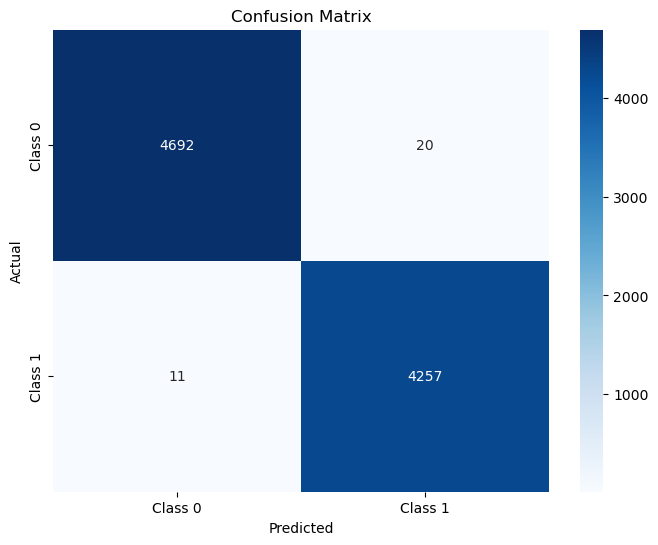

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Now you can use plot_confusion_matrix function
plot_confusion_matrix(y_test, svm_prediction, classes=['Class 0', 'Class 1'])


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

# Define the CNN model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy}')

NameError: name 'vocab_size' is not defined